In [2]:
import matplotlib.pyplot as plt
import json
import os
import requests
import pandas as pd
import dateparser
from collections import defaultdict
import xmltodict
from functions import *
import numpy as np

In [20]:
def get_articles_df(df_data, query_key, query_terms):
    new_df = None
    if type(query_terms)==str: query_terms = [query_terms]
    for d in query_terms:
        temp_df = df_data[df_data[query_key].apply(lambda x: d.lower() in [i.lower() for i in x])]
        if new_df is None: new_df = temp_df
        else: new_df = pd.concat([new_df, temp_df])
    return new_df

def get_division_articles(df_data, divisions):
    return get_articles_df(df_data, 'divisions', divisions)

def get_district_articles(df_data, districts):
    return get_articles_df(df_data, 'districts', districts)

## Get Division and District GeoID Mapping

Get all GeoIDs from data and store the name associated with them. This way, don't have to call the api every time to find the geoID

In [4]:
run_GeoID_save = False

In [5]:
if run_GeoID_save:
    arr = []
    # First extract all locations related to Bangladesh
    for t in twitter_df['locations']:
        innerArr = []
        for tt in t:
            # If Bangladesh GeoID and type of location not country
            if tt['level_0_region'] == 'g-1210997' and tt['type']!='country':
                innerArr.append(tt)
        arr.append(innerArr)

    # For all extracted locations - get level_1_region as division.
    # Query api to get division name
    divisionGeoIDMap = {}
    for gID in set([a['level_1_region'] for aa in arr for a in aa]):
        geoID = gID.split('-')[1]
        url = 'http://api.geonames.org/get?geonameId={}&username=tvp2107'
        resp = requests.get(url.format(geoID))
        divisionGeoIDMap[gID] = xmltodict.parse(resp.text)['geoname']['adminName1']
    divisionGeoIDMap

    # For all location if type != adm1 - take location_ID as districts
    districtGeoIDMap = {}
    for gID in set([a['location_ID'] for aa in arr for a in aa if a['type']!='adm1']):
        try:
            geoID = gID.split('-')[1]
            url = 'http://api.geonames.org/get?geonameId={}&username=tvp2107'
            resp = requests.get(url.format(geoID))
            districtGeoIDMap[gID] = xmltodict.parse(resp.text)['geoname']['adminName2']
        except Exception as e:
            print(gID)
            continue
    districtGeoIDMap

    json.dump({'divisionGeoIDMap': divisionGeoIDMap, 'districtGeoIDMap': districtGeoIDMap}, open('GeoIDMap.json','w'), indent=2)


## Load GeopID and extract location

Load the saved geoIDs and then extract division and district

In [6]:
twitter_df = pd.read_json('other_data/tweets.json') #Tweets
GeoIDMap = json.load(open('timeseries_data/GeoIDMap.json')) #Geo-ID list

In [7]:
# Seperate out all Bangla tweets (if toponym is Bangla)
isBangla = []
for t in twitter_df['locations']:
    check = True
    for tt in t:
        if tt['toponym']=='bangladesh':
            check = False
    isBangla.append(not check)
twitter_df['isBangla'] = isBangla
twitter_df = twitter_df[twitter_df['isBangla']] # Keep only Bangla Tweets

In [8]:
# For all bangla tweets: get lever_1_region = Division, location_ID = district
divisionTweets, districtTweets = [], []
for t in twitter_df['locations']:
    innerDiv, innerDist = [], []
    for tt in t:
        if tt['level_0_region'] == 'g-1210997': # Bangladesh GeoID
            # Get the location associated with division GeoID
            innerDiv.append(GeoIDMap['divisionGeoIDMap'].get(tt['level_1_region'],None))
            # Get the location associated with district GeoID. If this is 
            innerDist.append(GeoIDMap['districtGeoIDMap'].get(tt['location_ID'],None))
    while None in innerDiv: innerDiv.remove(None)
    while None in innerDist: innerDist.remove(None)
    divisionTweets.append(innerDiv)
    districtTweets.append(innerDist)
twitter_df['divisions'] = divisionTweets
twitter_df['districts'] = districtTweets

In [16]:
# Manual name mapping cause API sent these results, however, my data has different names
nameMap = {
    'Rajshahi Division': 'Rajshahi',
    'Mymensingh Division': 'Mymensingh',
    'Rangpur Division': 'Rangpur',
    'Shariatpur District': 'Shariatpur',
    'Maulvibazar District': 'Maulvibazar'
}
reverseNameMap = {v:k for k,v in nameMap.items()}

In [10]:
# Get dates in the format
dates = [str(row[1]['date'].year) + '-' + str(row[1]['date'].month) + '-' + str(row[1]['date'].day) 
         for row in twitter_df.iterrows()]
twitter_df['dates'] = dates


In [11]:
def saveTwitterData(df, save_file=''):
    df2 = df.groupby('dates').count().sort_values(by='dates')['id'].reset_index()
    dfList = [(r[1]['dates'], r[1]['id']) for r in df2.iterrows()]
    dfList = complete_day(dfList)
    dfDict = {i:j for (i,j) in dfList}
    json.dump(dfDict, open(save_file, 'w'), indent=2)

## Plotting to understand data

In [23]:
# Get all divisions and all districts
tweetDivisions = set()
for t in twitter_df['divisions']:
    tweetDivisions = tweetDivisions.union(set(t))
tweetDivisions = list(tweetDivisions)
tweetDistricts = set()
for t in twitter_df['districts']:
    tweetDistricts = tweetDistricts.union(set(t))
tweetDistricts = list(tweetDistricts)

In [24]:
arr2 = []
for dist in tweetDistricts: arr2.append((dist, len(get_district_articles(twitter_df, dist))))
arr2.sort(key=lambda x:x[1], reverse=True)

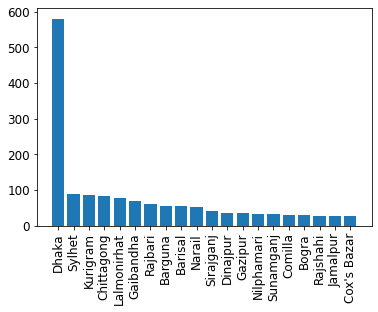

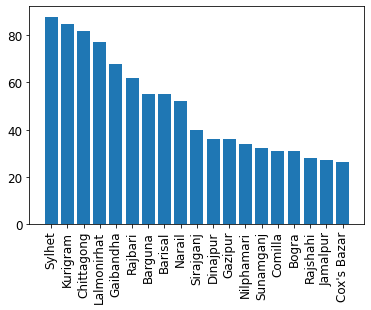

In [25]:
plt.bar([i[0] for i in arr2[:20]], [i[1] for i in arr2[:20]])
plt.xticks(rotation='vertical')
plt.show()
plt.bar([i[0] for i in arr2[1:20]], [i[1] for i in arr2[1:20]])
plt.xticks(rotation='vertical')
plt.show()

In [26]:
arr2 = []
for div in tweetDivisions: arr2.append((div, len(get_division_articles(twitter_df, div))))
arr2.sort(key=lambda x:x[1], reverse=True)

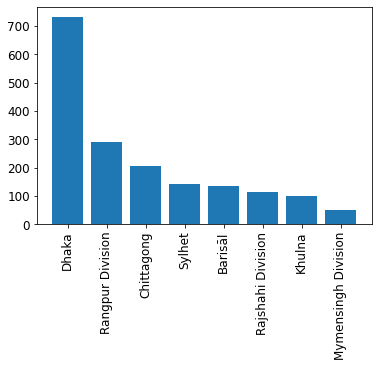

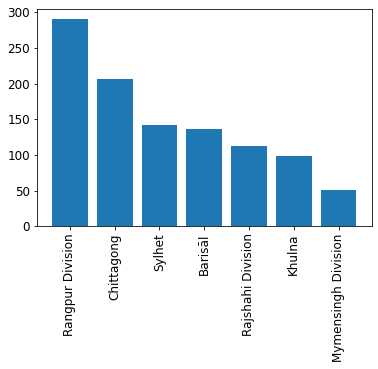

In [28]:
plt.bar([i[0] for i in arr2], [i[1] for i in arr2])
plt.xticks(rotation='vertical')
plt.show()
plt.bar([i[0] for i in arr2[1:]], [i[1] for i in arr2[1:]])
plt.xticks(rotation='vertical')
plt.show()

In [36]:
def plot_year_yearmonth_load(load_filepath, main_title='', plot=True, aggType=None, skip=None):
    data = json.load(open(load_filepath))
    dataList = complete_day([(k,v) for k,v in data.items()], aggType=aggType)
    if plot:
        plot_timeseries(
            [{'count_list': dataList, 'label':'Tweets', 
                 'color':'r', 'ylabel':'# tweets'}],
                main_title + ' Twitter', 'Date', '# Tweets', True, skip=skip)

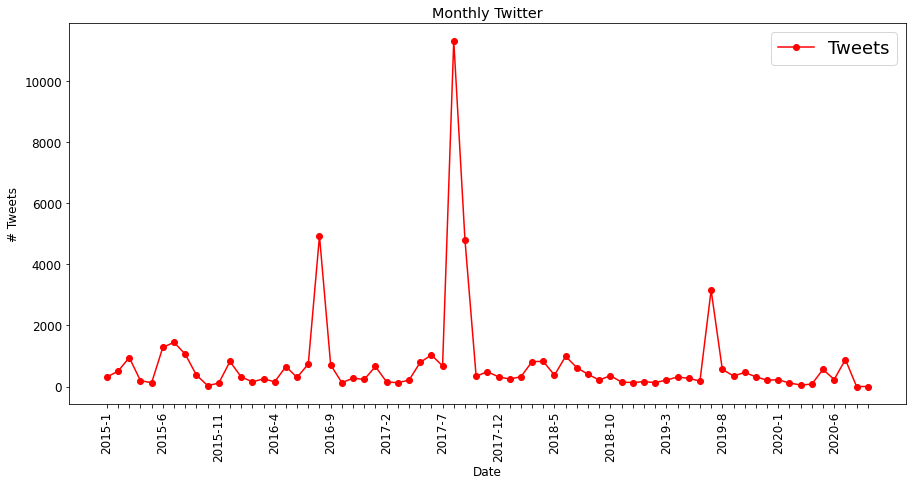

In [37]:
# plot_year_yearmonth_load('timeseries_data/TwitterAll.json', skip=60)
# plot_year_yearmonth_load('timeseries_data/TwitterBarisāl.json', main_titla='Barisal', skip=60)
# plot_year_yearmonth_load('timeseries_data/TwitterSylhet.json', main_titla='Sylhet', skip=60)
# plot_year_yearmonth_load('timeseries_data/TwitterMymensingh.json', main_titla='Mymensingh', skip=60)
# plot_year_yearmonth_load('timeseries_data/TwitterKhulna.json', main_titla='Khulna', skip=60)
# plot_year_yearmonth_load('timeseries_data/TwitterDhaka.json', main_titla='Dhaka', skip=60)
# plot_year_yearmonth_load('timeseries_data/TwitterChittagong.json', main_titla='Chittagong', skip=60)
# plot_year_yearmonth_load('timeseries_data/TwitterRangpur.json', main_titla='Rangpur', skip=60)

plot_year_yearmonth_load('timeseries_data/TwitterAll.json', main_title='Monthly', aggType='month', skip=5)
# plot_year_yearmonth_load('timeseries_data/TwitterBarisāl.json', main_titla='Barisal(Monthly)', aggType='month', skip=5)
# plot_year_yearmonth_load('timeseries_data/TwitterSylhet.json', main_titla='Sylhet(Monthly)', aggType='month', skip=5)
# plot_year_yearmonth_load('timeseries_data/TwitterMymensingh.json', main_titla='Mymensingh(Monthly)', aggType='month', skip=5)
# plot_year_yearmonth_load('timeseries_data/TwitterKhulna.json', main_titla='Khulna(Monthly)', aggType='month', skip=5)
# plot_year_yearmonth_load('timeseries_data/TwitterDhaka.json', main_titla='Dhaka(Monthly)', aggType='month', skip=5)
# plot_year_yearmonth_load('timeseries_data/TwitterChittagong.json', main_titla='Chittagong(Monthly)', aggType='month', skip=5)
# plot_year_yearmonth_load('timeseries_data/TwitterRangpur.json', main_titla='Rangpur(Monthly)', aggType='month', skip=5)